In [ ]:
import glob
import os
import torch
from torch import nn
from PIL import Image
import numpy as np
from diffusers import UniPCMultistepScheduler
from src.models.stage2_inpaint_unet_2d_condition import Stage2_InapintUNet2DConditionModel

from torchvision import transforms
from diffusers.models.controlnet import ControlNetConditioningEmbedding
from transformers import CLIPImageProcessor
from transformers import Dinov2Model
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel,ControlNetModel,DDIMScheduler
from src.pipelines.PCDMs_pipeline import PCDMsPipeline
from single_extract_pose import inference_pose

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    print(w, h)
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def load_mydict(model_ckpt_path):
    model_sd = torch.load(model_ckpt_path, map_location="cpu")["module"]

    image_proj_model_dict = {}
    pose_proj_dict = {}
    unet_dict = {}
    for k in model_sd.keys():
        if k.startswith("pose_proj"):
            pose_proj_dict[k.replace("pose_proj.", "")] = model_sd[k]

        elif k.startswith("image_proj_model"):
            image_proj_model_dict[k.replace("image_proj_model.", "")] = model_sd[k]


        elif k.startswith("unet"):
            unet_dict[k.replace("unet.", "")] = model_sd[k]
        else:
            print(k)
    return image_proj_model_dict, pose_proj_dict, unet_dict

class ImageProjModel(torch.nn.Module):
    """SD model with image prompt"""
    def __init__(self, in_dim, hidden_dim, out_dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, out_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):  
        return self.net(x)

In [23]:
device = "cuda:6"
pretrained_model_name_or_path ="stabilityai/stable-diffusion-2-1-base"
image_encoder_path = "facebook/dinov2-giant"
model_ckpt_path = "./PCDMs_ckpt.pt"


In [ ]:
clip_image_processor = CLIPImageProcessor()
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

generator = torch.Generator(device=device).manual_seed(42)
unet = Stage2_InapintUNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16,subfolder="unet",in_channels=9, low_cpu_mem_usage=False, ignore_mismatched_sizes=True).to(device)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path,subfolder="vae").to(device, dtype=torch.float16)
image_encoder = Dinov2Model.from_pretrained(image_encoder_path).to(device, dtype=torch.float16)
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

image_proj_model = ImageProjModel(in_dim=1536, hidden_dim=768, out_dim=1024).to(device).to(dtype=torch.float16)
pose_proj_model = ControlNetConditioningEmbedding(
    conditioning_embedding_channels=320,
    block_out_channels=(16, 32, 96, 256),
    conditioning_channels=3).to(device).to(dtype=torch.float16)

# load weight
image_proj_model_dict, pose_proj_dict, unet_dict = load_mydict(model_ckpt_path)
image_proj_model.load_state_dict(image_proj_model_dict)
pose_proj_model.load_state_dict(pose_proj_dict)
unet.load_state_dict(unet_dict)

pipe = PCDMsPipeline.from_pretrained(pretrained_model_name_or_path, unet=unet,  torch_dtype=torch.float16, scheduler=noise_scheduler,feature_extractor=None,safety_checker=None).to(device)

print('====================== model load finish ===================')

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


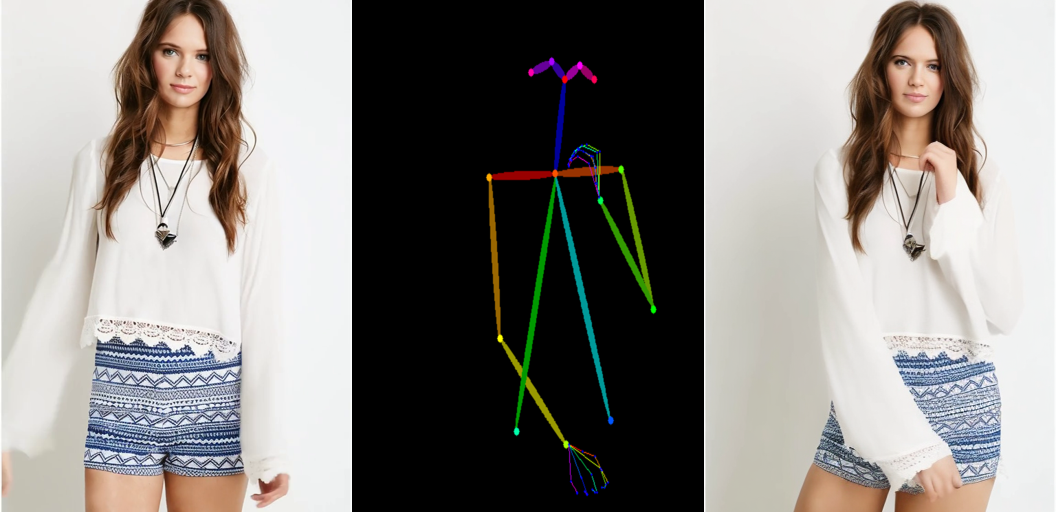

In [95]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img1.png'
target_pose_img = './imgs/pose1.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


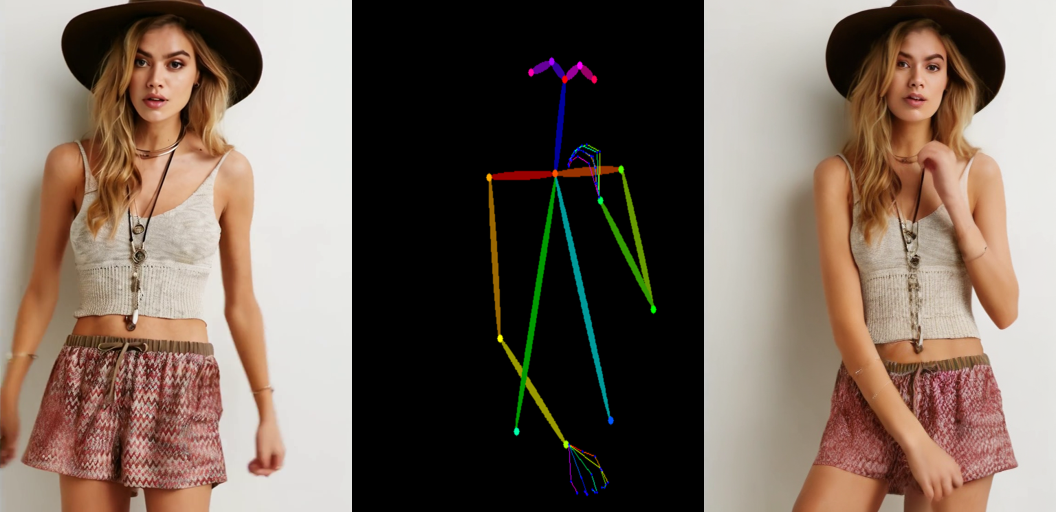

In [96]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img2.png'
target_pose_img = './imgs/pose1.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


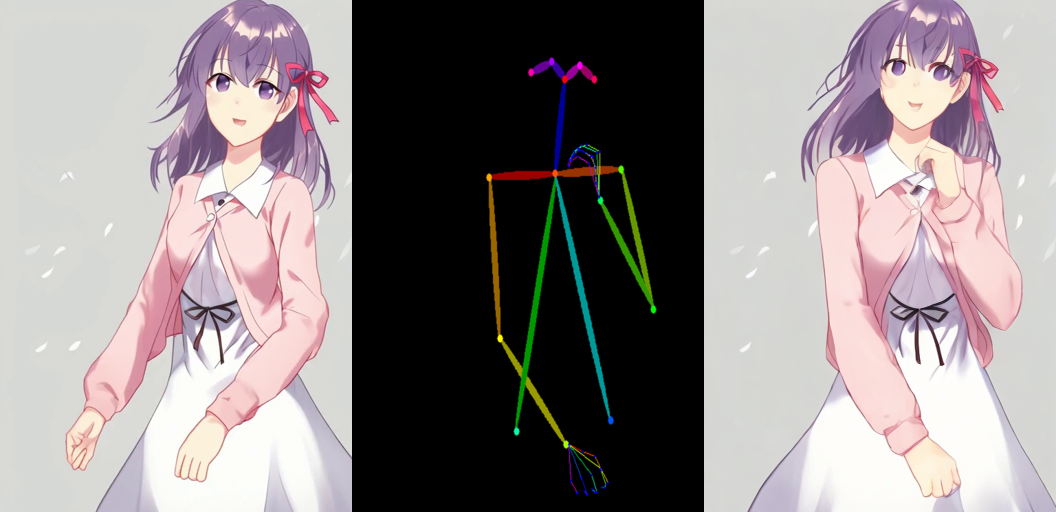

In [97]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img3.png'
target_pose_img = './imgs/pose1.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


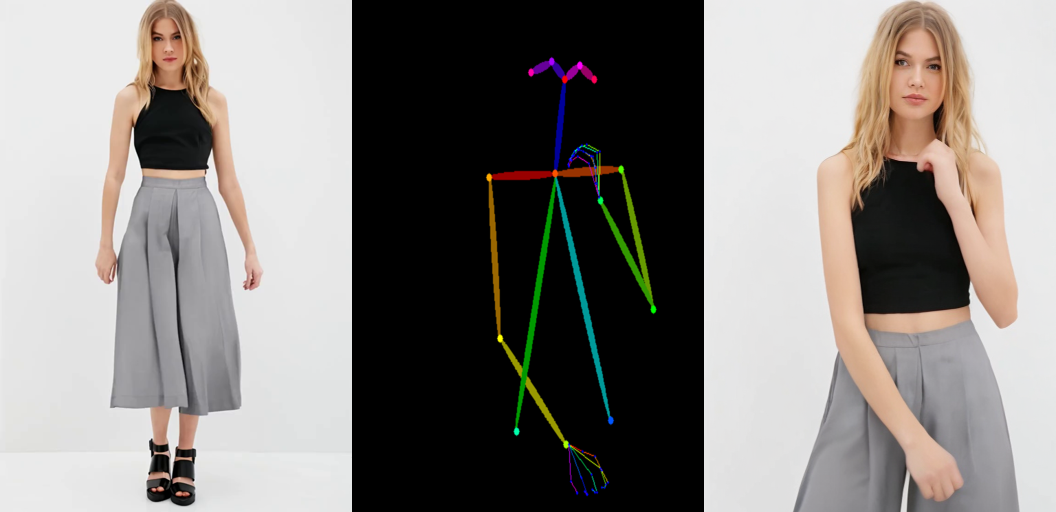

In [99]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img4.png'
target_pose_img = './imgs/pose1.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


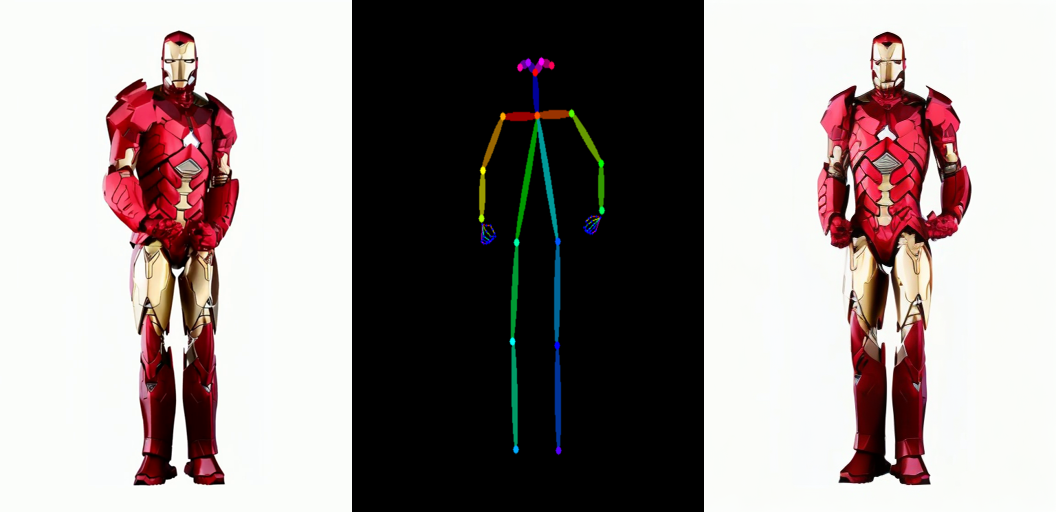

In [101]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img5.png'
target_pose_img = './imgs/pose2.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


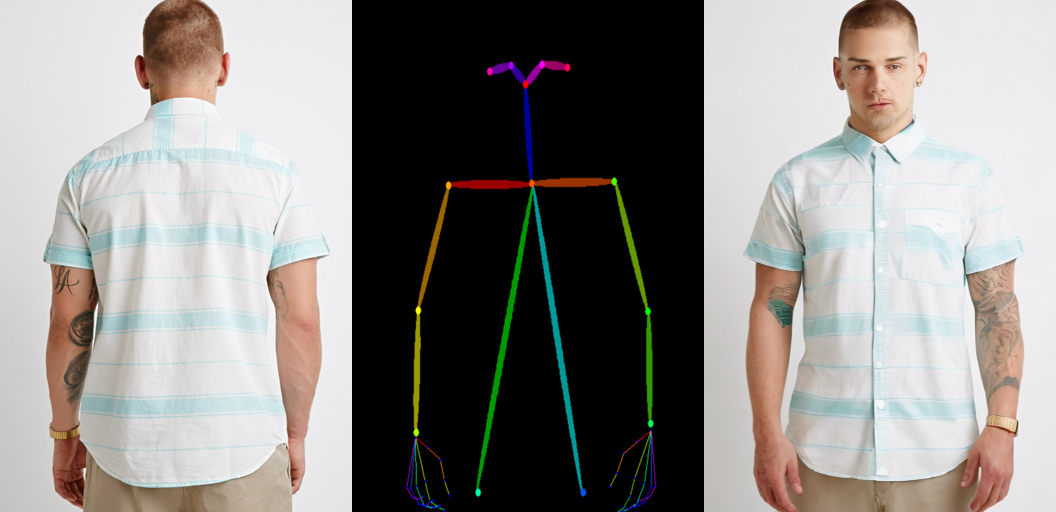

In [102]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img6.png'
target_pose_img = './imgs/pose3.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


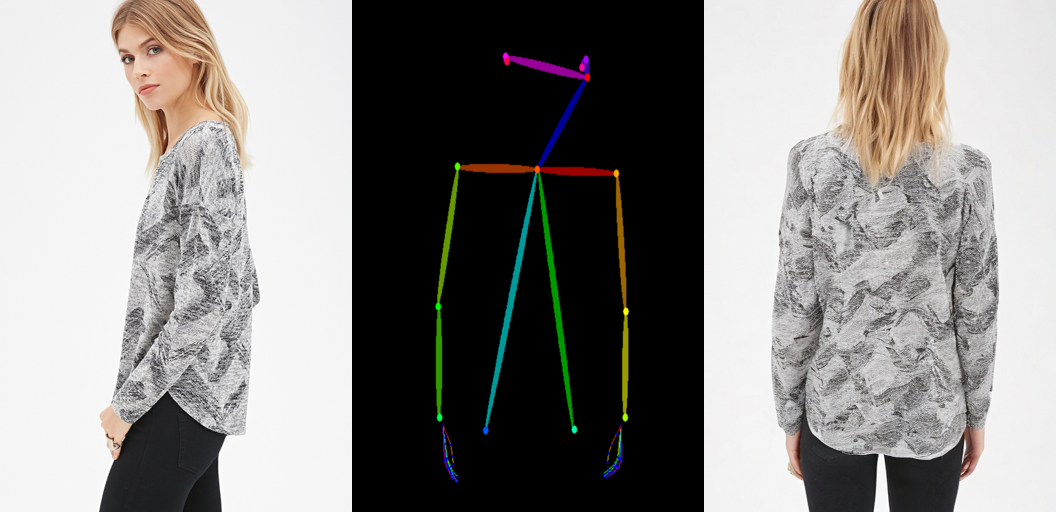

In [104]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img7.png'
target_pose_img = './imgs/pose4.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


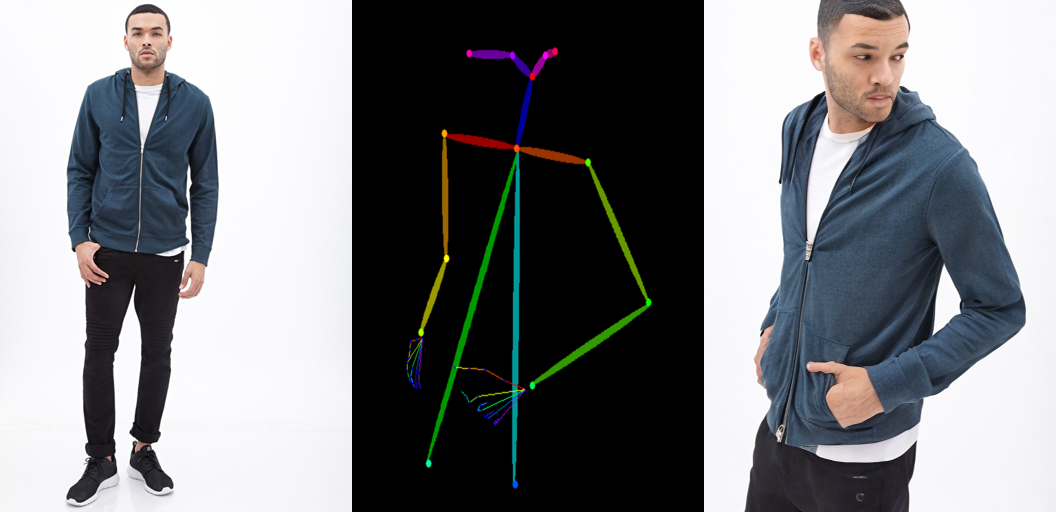

In [105]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img8.png'
target_pose_img = './imgs/pose5.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid

Loads checkpoint by local backend from path: ./ckpts/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by local backend from path: ./ckpts/dw-ll_ucoco_384.pth
source image width: 512, height: 512


  0%|          | 0/50 [00:00<?, ?it/s]

352 512


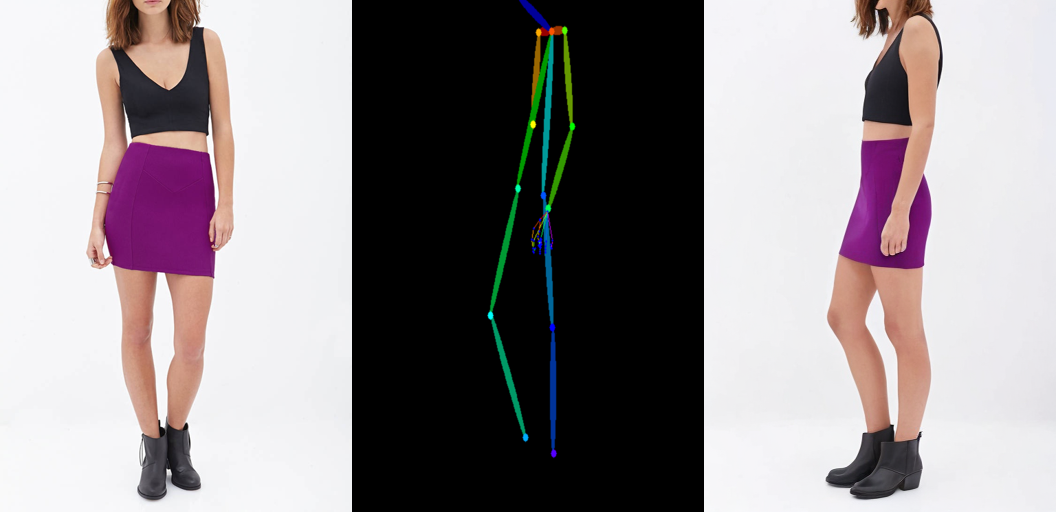

In [76]:
num_samples = 1
image_size = (512, 512)
s_img_path = './imgs/img9.png'
target_pose_img = './imgs/pose6.png'


s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))


clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values
vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)

mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)


with torch.inference_mode():
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215

    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))

bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds,
    height=image_size[1],
    width=image_size[0]*2,
    num_images_per_prompt=num_samples,
    guidance_scale=2.0,
    generator=generator,
    num_inference_steps=50,
).images[-1]

save_output = []
result = output.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
save_output.append(result.resize((352, 512), Image.BICUBIC))
save_output.insert(0, t_pose.resize((352, 512), Image.BICUBIC))
save_output.insert(0, s_img.resize((352, 512), Image.BICUBIC))
grid = image_grid(save_output, 1, 3)
grid